In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Generate a test signal 
The holohil transmitters are lightweight low power radios with an extremely simple transmit pattern. The radios simply transmit a carrier tone for some on time and then turn off for some off time. The transmit frequency ranges from 168-172 Mhz, the on time is roughly 20ms, and the off time is around 2 seconds. These values are not finalized, and still need to be verifyied by measureing the actual transmitter in the lab. 

For the purpose of these simulations I am using a 10,000 Hz carrier frequency, 0.2 second on time and 0.8 second off time. The signal generation is wrapped into a fucntion so that these parametera are all easily tunable. Using the 168 Mhz carrier was just casueing the simulations to be too slow on my laptop so to test the dsp algorithms its faster to simulate with the values I chose here.  

link to holohil website:
https://urldefense.com/v3/__https://www.holohil.com/__;!!Mih3wA!HbQnq6niydY-kFObMMRw3mgXM2fI1lAuIpneJzDIelarT-uKcGR3wkEr5Uug72Nmi8dnDVEPyeTfVjI$

In [2]:
fc = 10000#168-172 Mhz
on_time = 0.2 
off_time = 0.8
#not sure what to use for fc, might need to brush up on sampling theory
#actual USRPs sample at 100 Mhz referenced to the fc, not sure how to model this in simualtion
#for now just using a fixed sample rate that is more then the Nyquist rate
fs = 5*fc

In [3]:
def gen_test_sig(fc:float, on_time:float, off_time:float, fs:float)->tuple:
    t = np.arange(0,on_time+off_time,1/fs)
    t_on = np.arange(0,on_time, 1/fs)
    s_on = np.cos(2*np.pi*fc*t_on)
    s_off = np.zeros(int(off_time/(1/fs)))
    s = np.hstack((s_on,s_off))
    assert len(s)==len(t), "time ({}) and signal ({}) array lengths must match".format(len(t), len(s))
    return t,s

In [4]:
t, tx_sig = gen_test_sig(fc, on_time, off_time, fs)

(-1.1, 1.1)

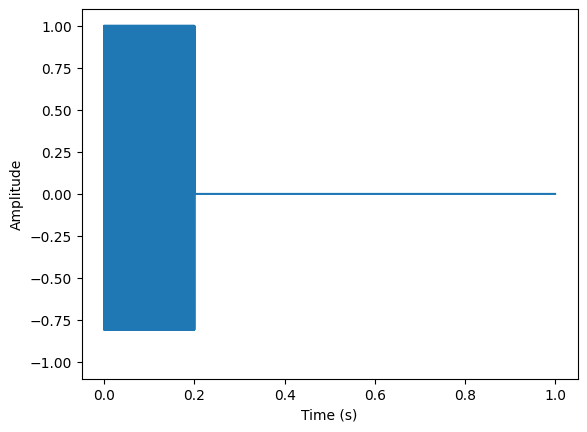

In [5]:
plt.plot(t,tx_sig)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim([-1.1,1.1])

# Passing the signal through a channel
The next step is to simulate passing the signal through a channel. The simplest channel model just adds gaussian noise. For now I stick with this simple model, but put some effort to write the code in a way that we can add more complextiy to our channel model later. 

In [10]:
#For now we are only adding awgn and cto
def add_awgn(s:np.array, sigma2:float)->np.array:
    n = np.sqrt(sigma2/2) * (np.random.randn(len(s)) + 1j*np.random.randn(len(s)))
    return s+n
def add_cto(signal:np.array, sto:float)->np.array:
    return np.hstack(( np.zeros(sto), signal, np.zeros(sto) ))

In [11]:
#Not using any of these yet, but I have the functions from 268 so just pasting here cand might be useful in the future
def add_cfo(signal:np.array, cfo:float)->np.array:
    return signal * np.exp(2j*np.pi*cfo*np.arange(len(signal)))
def apply_channel_filter(signal:np.array, h:np.array)->np.array:
    return sp.signal.lfilter(h, (1), signal)

In [12]:
#should use kwargs here, look into this later. For now just add sigma2, and cto as args since we are only adding awgn and delay
#if kwargs are added then this one function can add whichever channel effects we want to specify
def add_channel_effects(signal:np.array, sigma2:float, cto:float)->np.array:
    delayed_signal = add_cto(signal, cto)
    return add_awgn(delayed_signal, sigma2)

In [13]:
sigma2 = 0.025
delay = 0.14 #seconds
cto = int(delay/(1/fs))
rec_sig = add_channel_effects(tx_sig, sigma2, cto)
t2 = 1/fs*np.arange(0,len(rec_sig))
assert(len(t2)==len(rec_sig))

C:\Users\josep\Documents\UCSD\WES\Capstone\pyloc_env\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


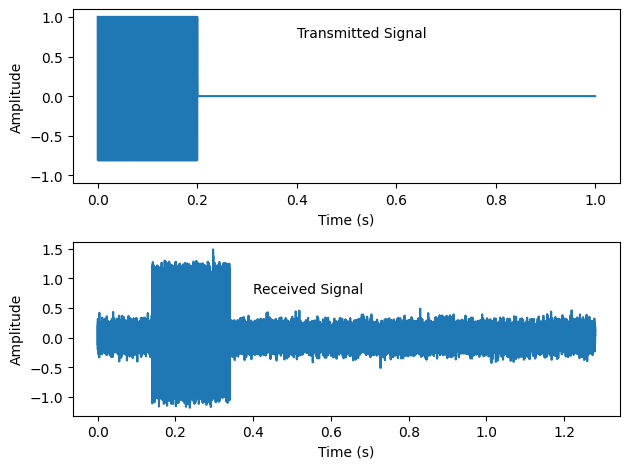

In [14]:
plt.subplot(211)
plt.plot(t,tx_sig)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim([-1.1,1.1])
plt.text(0.4,0.75,"Transmitted Signal")

plt.subplot(212)
plt.plot(t2,rec_sig)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.text(0.4,0.75,"Received Signal")
plt.tight_layout()

# DSP step 1: Filtering
The first step in the DSP is to pass the received signal through a bandpass filter. 

In [15]:
# Define filter parameters
f1 = 0.19  # Lower cutoff frequency (normalized)
f2 = 0.21  # Upper cutoff frequency (normalized)
fcenter = 0.2   # Center frequency       (normalized)
numtaps = 101  # Filter length

# Calculate filter coefficients
h = sp.signal.firwin(numtaps, [f1*fs, f2*fs], pass_zero=False, fs=fs)

# Get Frequency response
f, H_f = sp.signal.freqz(h, 1, fs=fs)

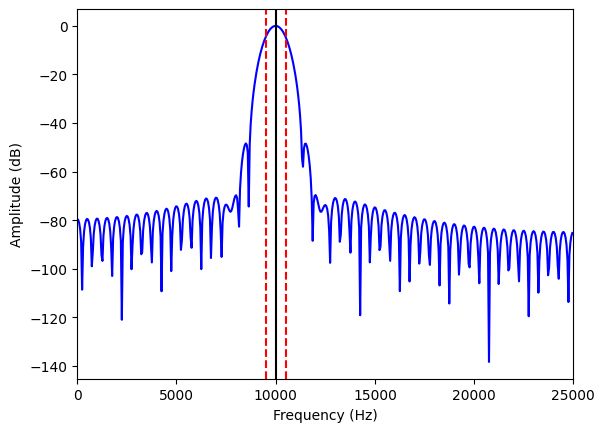

In [16]:
#plot the response
plt.plot(f, 20 * np.log10(abs(H_f)), 'b')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.axvline(fcenter * fs, color='k')
plt.axvline(f1 * fs, color='r', linestyle='--')
plt.axvline(f2 * fs, color='r', linestyle='--')
plt.xlim(0, fs/2)
plt.show()

In [17]:
def my_fft(x_n, fs, fftlen=-1, shifted=True):
    if fftlen < len(x_n): fftlen = len(x_n)
    x_f = np.fft.fft(x_n, fftlen)
    if shifted:
        f = np.arange(-fs/2, fs/2, fs/fftlen)
        x_f = np.fft.fftshift(x_f)
    else:
        f = np.arange(0, fs, fs/fftlen)
    return (f, x_f)

def dB(x):
    return 20*np.log10(np.abs(x))

In [18]:
#pass the received signal through the filter
fil_sig = sp.signal.lfilter(h, 1, rec_sig)

f, X1 = my_fft(rec_sig,fs)
f, X2 = my_fft(fil_sig,fs)

C:\Users\josep\Documents\UCSD\WES\Capstone\pyloc_env\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


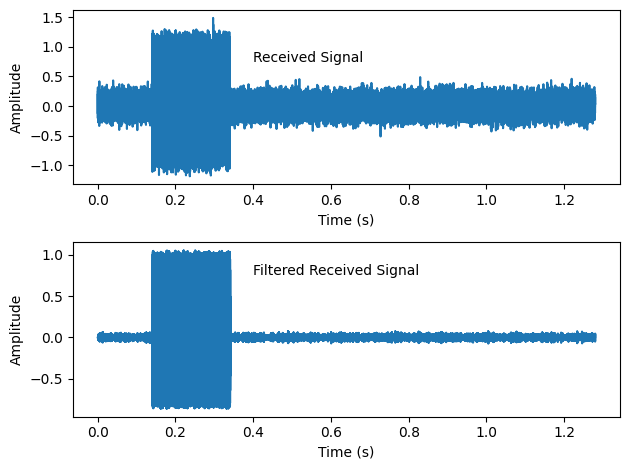

In [19]:
plt.subplot(211)
plt.plot(t2,rec_sig)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.text(0.4,0.75,"Received Signal")
plt.tight_layout()

plt.subplot(212)
plt.plot(t2,fil_sig)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.text(0.4,0.75,"Filtered Received Signal")

plt.tight_layout()

# DSP step 2: Cross Correlation
In this simulation the np.correlatie fucntion is used to easily find the corrrlation result. In practice we will need to implement the correlation in C++, so we need to look into efficient correlation functions that we might be able to use. 

Interestingly it looks like filtering before the correlation might not actually be necessay. The plots below show similar results wheather the filtering is used or not. It might be best to just implement the cross correlation first then worry about filtering only if its needed. 

In [20]:
xcorr_nofilter = np.correlate(rec_sig, tx_sig)
xcorr_filter = np.correlate(fil_sig, tx_sig)
true_lag = cto

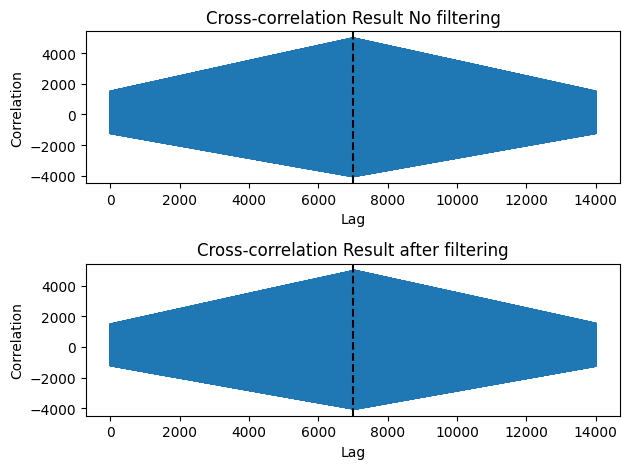

In [21]:
# Plot the result
plt.subplot(211)
plt.plot(xcorr_nofilter)
plt.axvline(true_lag, color='k', linestyle='--')
plt.title('Cross-correlation Result No filtering')
plt.xlabel('Lag')
plt.ylabel('Correlation')


plt.subplot(212)
plt.plot(xcorr_filter)
plt.axvline(true_lag, color='k', linestyle='--')
plt.title('Cross-correlation Result after filtering')
plt.xlabel('Lag')
plt.ylabel('Correlation')

plt.tight_layout()

# DSP step 3: Find the peak of the correlation
We can easliy find the correlation peak using the built in `np.argmax()` funciton. We need to look into effcient algorthims in C++ to find the max value in an array so that we can implement this step in the actual DSP application. 

At least in this simulaiton the reult was worse when we used the filter before running the correlation. The true offset was hardset to 7000 samples. 

In [24]:
TOA_est_no_filter = np.argmax(xcorr_nofilter)
TOA_est_filter = np.argmax(xcorr_filter)

print('TOA No filter: \n\t Sample # = {} \n\t Time = {}'.format(TOA_est_no_filter, TOA_est_no_filter*(1/fs)))
print('TOA with filter: \n\t Sample # = {} \n\t Time = {}'.format(TOA_est_filter, TOA_est_filter*(1/fs)))

TOA No filter: 
	 Sample # = 7000 
	 Time = 0.14
TOA with filter: 
	 Sample # = 7050 
	 Time = 0.14100000000000001
